### Modelo de Clasificación de Perros & Gatos

        Introducción
<div style="text-align: justify;">

La presente tarea se enfoca en analizar la implementación de un modelo propuesto por uno mismo por medio de la librería de TensorFlow, así como la función en donde se introducirá una imagen de la base de datos propuesta para la visualización de la predicción del modelo conforme a la clasificación de perros y gatos. La base de datos a utilizar contiene un total de 4000 imágenes de perros y gatos, la cual fue propuesta en clase. Así bien, se utilizó el
formato de datos binarios HDF5, el cual permite almacenar grandes cantidades de
conjuntos de datos en un solo archivo, categorizarlos y etiquetarlos como se desee.
</div>

        Código

Montar Drive

In [1]:
import sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
##Librerias
import os
import zipfile
import glob, cv2, numpy as np
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import keras
from keras import optimizers
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils.vis_utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

Descargar archivo .zip

In [8]:
!wget --no-check-certificate \
   https://www.dropbox.com/s/0j7s080efbfh8gc/cats_and_dogs_small.zip?dl=0\
   -O cats_and_dogs_small.zip

--2022-03-14 03:45:18--  https://www.dropbox.com/s/0j7s080efbfh8gc/cats_and_dogs_small.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/0j7s080efbfh8gc/cats_and_dogs_small.zip [following]
--2022-03-14 03:45:19--  https://www.dropbox.com/s/raw/0j7s080efbfh8gc/cats_and_dogs_small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc3ece6f4f2d2e852b0028153d42.dl.dropboxusercontent.com/cd/0/inline/BhYPPjAn9Efdt8bzSGbi9yHms36N32OxsGD4S6C6WCKa2G9EWt_fzIl-uW4D68HN_7LaN191XAdQ9a_wpKNESOdDiNGRb9XkRjpFXD4XX2X1XyaCEI3RmVNa0gPD3CSuBY1p-_Jkos5HrD2yB-lxT_XIzcQcLg60fsXKD-QXQlzWLg/file# [following]
--2022-03-14 03:45:19--  https://uc3ece6f4f2d2e852b0028153d42.dl.dropboxusercontent.com/cd/0/inline/BhYPPjAn9Efdt8bzSGbi9yHms36N32

Descomprimir el archivo .zip

In [9]:
local_zip = 'cats_and_dogs_small.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('')
zip_ref.close()

Leer imagenes(cv2,Image)

<div style="text-align: justify;">
En las siguientes líneas, se modifica el nombre de la ruta de cada imagen conforme a su categoría, además de modificar el formato de las imágenes a formato .jpg. De igual manera, se modifica el tamaño de cada imagen de la base de datos, para después agregarla al conjunto de X. Así bien, se crea el conjunto Y, en base a la imagen agregada al conjunto de X, en donde si la imagen corresponde a la categoría de gatos se añade un 0 al conjunto de Y y si la imagen corresponde a la categoría de perros se añade un 1 al conjunto de Y.
</div>

In [10]:
categorias = ['cats', 'dogs']

X = []
Y = []
for categoria in tqdm(categorias):  
  ruta_imgs = glob.glob('./cats_and_dogs_small/'+ categoria +'/*.jpg')
  for ruta_img in ruta_imgs:
    img = cv2.resize(cv2.imread(ruta_img), (150, 150))
    X.append(img)
    if categoria == 'cats':
      Y.append(0)
    else:
      Y.append(1)

100%|██████████| 2/2 [00:09<00:00,  4.78s/it]


Crearlas variables X e Y

<div style="text-align: justify;">
A continuación, se modifica la lista de X en una matriz de tipo ‘uinut8’. Así bien, la lista de Y se modifica de igual forma y se cambia la forma de la matriz para que únicamente sea de una columna.
</div>

In [11]:
X = np.asarray(X).astype('uint8')
Y = np.expand_dims(np.asarray(Y).astype('uint8'),axis =1)

In [12]:
print(type(X[0,0,0,0]), X.shape)
print(type(Y[0,0]), Y.shape)

<class 'numpy.uint8'> (4000, 150, 150, 3)
<class 'numpy.uint8'> (4000, 1)


In [13]:
print(len(X))
print(len(Y))
print(Y)

4000
4000
[[0]
 [0]
 [0]
 ...
 [1]
 [1]
 [1]]


Aleatorizar variables X e Y

In [14]:
X,Y = shuffle(X,Y)
print(Y)

[[0]
 [1]
 [1]
 ...
 [0]
 [0]
 [0]]


Guardar en HDF5



In [4]:
path_h5 = '/content/drive/MyDrive/Colab Notebooks/Deep Learning/'

Escribir el archivo HDF5

In [15]:
with h5py.File(path_h5 + 'dataset_cat_dogs.hdf5', 'w') as hf:
    x = hf.create_dataset('X', data = X, shape = X.shape, compression = 'gzip', compression_opts = 9,chunks = True)
    y = hf.create_dataset('Y', data = Y, shape = Y.shape, compression = 'gzip', compression_opts = 9,chunks = True)

Leer el archivo HDF5

In [16]:
with h5py.File(path_h5 + 'dataset_cat_dogs.hdf5', 'r') as hf:
    X = hf['X'][:]
    Y = hf['Y'][:]

In [17]:
print('Conjunto de datos en X:',X.shape)
print('Conjunto de datos en Y:',Y.shape)

Conjunto de datos en X: (4000, 150, 150, 3)
Conjunto de datos en Y: (4000, 1)


Normalización

In [18]:
X=X.astype('float32')
X/=255.0

Cambiando etiquetas del conjunto Y a categorización onehot

In [19]:
Y=tf.keras.utils.to_categorical(Y)

División del conjunto de datos: Conjunto de entrenamiento, validación y prueba.

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size = 0.8)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size = 0.75)

In [21]:
print( x_train.shape, x_val.shape, x_test.shape)
print( y_train.shape, y_val.shape, y_test.shape)

(2400, 150, 150, 3) (800, 150, 150, 3) (800, 150, 150, 3)
(2400, 2) (800, 2) (800, 2)


#### Modelo #1 

In [85]:
model1 = Sequential()
model1.add(Conv2D(32,(3,3), activation='relu', input_shape=(150, 150, 3)))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(64, (3,3), activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Conv2D(32, (3,3), activation='relu'))
model1.add(MaxPooling2D(2,2))
model1.add(Flatten())
model1.add(Dropout(0.5))
model1.add(Dense(512, activation='relu'))
model1.add(Dense(2,activation="softmax"))

In [86]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 17, 17, 64)      

Visualización de la estructura

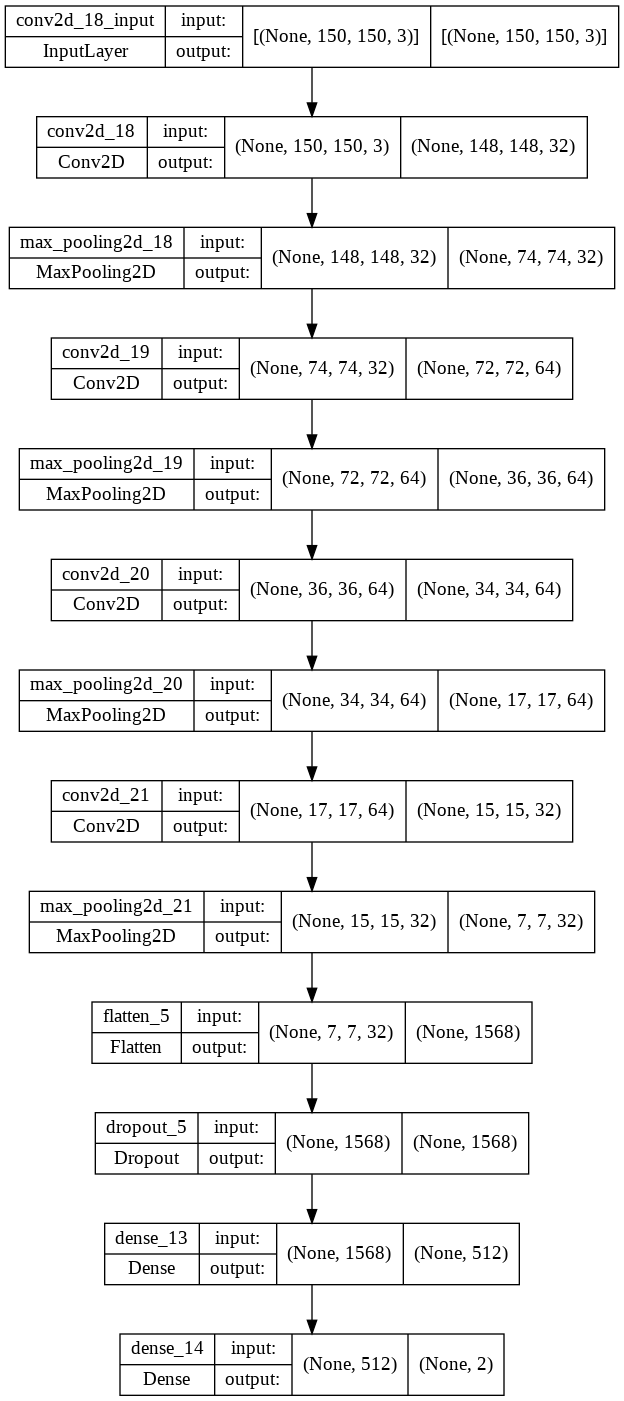

In [144]:
plot_model(model1, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

In [88]:
model1.compile(optimizer=RMSprop(learning_rate=1e-4),loss='binary_crossentropy',metrics = ['accuracy'])

In [89]:
history1 = model1.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_data=(x_val, y_val), verbose = 1)

Epoch 1/100
19/19 [==============================] - 5s 200ms/step - loss: 0.6929 - accuracy: 0.4913 - val_loss: 0.6916 - val_accuracy: 0.4975
Epoch 2/100
19/19 [==============================] - 3s 183ms/step - loss: 0.6908 - accuracy: 0.5275 - val_loss: 0.6890 - val_accuracy: 0.4975
Epoch 3/100
19/19 [==============================] - 3s 184ms/step - loss: 0.6876 - accuracy: 0.5421 - val_loss: 0.6844 - val_accuracy: 0.6000
Epoch 4/100
19/19 [==============================] - 3s 183ms/step - loss: 0.6818 - accuracy: 0.5754 - val_loss: 0.6760 - val_accuracy: 0.5675
Epoch 5/100
19/19 [==============================] - 3s 184ms/step - loss: 0.6758 - accuracy: 0.5854 - val_loss: 0.6682 - val_accuracy: 0.5987
Epoch 6/100
19/19 [==============================] - 3s 185ms/step - loss: 0.6698 - accuracy: 0.6075 - val_loss: 0.6609 - val_accuracy: 0.6275
Epoch 7/100
19/19 [==============================] - 3s 184ms/step - loss: 0.6663 - accuracy: 0.5863 - val_loss: 0.6579 - val_accuracy: 0.6200

Evaluación de la red entrenada

In [90]:
score1 = model1.evaluate(x_test, y_test,verbose=0)
print("Test loss:", score1[0])
print("Test accuracy:", score1[1])

Test loss: 0.5474550127983093
Test accuracy: 0.737500011920929


#### Modelo #2

In [65]:
model2 = Sequential()
model2.add(Conv2D(32,(3,3), activation='tanh', input_shape=(150, 150, 3)))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(64, (3,3), activation='tanh'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(64, (3,3), activation='tanh'))
model2.add(MaxPooling2D(2,2))
model2.add(Conv2D(32, (3,3), activation='tanh'))
model2.add(MaxPooling2D(2,2))
model2.add(Flatten())
model2.add(Dropout(0.5))
model2.add(Dense(512, activation='tanh'))
model2.add(Dense(2,activation="softmax"))

In [ ]:
model2.summary()

In [68]:
model2.compile(optimizer=RMSprop(learning_rate=1e-4),loss='binary_crossentropy',metrics = ['accuracy'])

In [91]:
history2 = model2.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_data=(x_val, y_val), verbose = 1)

Epoch 1/100
19/19 [==============================] - 4s 200ms/step - loss: 0.2699 - accuracy: 0.8888 - val_loss: 0.5909 - val_accuracy: 0.7400
Epoch 2/100
19/19 [==============================] - 3s 182ms/step - loss: 0.2824 - accuracy: 0.8842 - val_loss: 0.5763 - val_accuracy: 0.7588
Epoch 3/100
19/19 [==============================] - 3s 183ms/step - loss: 0.2608 - accuracy: 0.8946 - val_loss: 0.5510 - val_accuracy: 0.7500
Epoch 4/100
19/19 [==============================] - 3s 182ms/step - loss: 0.2786 - accuracy: 0.8800 - val_loss: 0.5777 - val_accuracy: 0.7638
Epoch 5/100
19/19 [==============================] - 3s 183ms/step - loss: 0.2517 - accuracy: 0.8908 - val_loss: 0.5721 - val_accuracy: 0.7513
Epoch 6/100
19/19 [==============================] - 3s 181ms/step - loss: 0.2597 - accuracy: 0.8875 - val_loss: 0.5704 - val_accuracy: 0.7663
Epoch 7/100
19/19 [==============================] - 3s 184ms/step - loss: 0.2490 - accuracy: 0.8963 - val_loss: 0.5891 - val_accuracy: 0.7412

Evaluación de la red entrenada

In [92]:
score2 = model2.evaluate(x_test, y_test,verbose=0)
print("Test loss:", score2[0])
print("Test accuracy:", score2[1])

Test loss: 0.6729769110679626
Test accuracy: 0.7612500190734863


#### Modelo #3 

In [93]:
model3 = Sequential()
model3.add(Conv2D(32,(3,3), activation='sigmoid', input_shape=(150, 150, 3)))
model3.add(MaxPooling2D(2,2))
model3.add(Conv2D(64, (3,3), activation='sigmoid'))
model3.add(MaxPooling2D(2,2))
model3.add(Conv2D(64, (3,3), activation='sigmoid'))
model3.add(MaxPooling2D(2,2))
model3.add(Conv2D(32, (3,3), activation='sigmoid'))
model3.add(MaxPooling2D(2,2))
model3.add(Flatten())
model3.add(Dropout(0.5))
model3.add(Dense(512, activation='sigmoid'))
model3.add(Dense(2,activation="softmax"))

In [94]:
model3.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_22 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_24 (Conv2D)          (None, 34, 34, 64)        36928     
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 17, 17, 64)      

In [95]:
model3.compile(optimizer=RMSprop(learning_rate=1e-4),loss='binary_crossentropy',metrics = ['accuracy'])

In [96]:
history3 = model3.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_data=(x_val, y_val), verbose = 1)

Epoch 1/100
19/19 [==============================] - 5s 196ms/step - loss: 0.7077 - accuracy: 0.4888 - val_loss: 0.6935 - val_accuracy: 0.5025
Epoch 2/100
19/19 [==============================] - 3s 183ms/step - loss: 0.7003 - accuracy: 0.4900 - val_loss: 0.7082 - val_accuracy: 0.5025
Epoch 3/100
19/19 [==============================] - 3s 183ms/step - loss: 0.6986 - accuracy: 0.5038 - val_loss: 0.6941 - val_accuracy: 0.5025
Epoch 4/100
19/19 [==============================] - 3s 182ms/step - loss: 0.6981 - accuracy: 0.4963 - val_loss: 0.6998 - val_accuracy: 0.5025
Epoch 5/100
19/19 [==============================] - 3s 181ms/step - loss: 0.7002 - accuracy: 0.4833 - val_loss: 0.6949 - val_accuracy: 0.4975
Epoch 6/100
19/19 [==============================] - 3s 183ms/step - loss: 0.6974 - accuracy: 0.4988 - val_loss: 0.6934 - val_accuracy: 0.5025
Epoch 7/100
19/19 [==============================] - 3s 184ms/step - loss: 0.6972 - accuracy: 0.4908 - val_loss: 0.7018 - val_accuracy: 0.4975

In [97]:
score3 = model3.evaluate(x_test, y_test,verbose=0)
print("Test loss:", score3[0])
print("Test accuracy:", score3[1])

Test loss: 0.6930124759674072
Test accuracy: 0.5087500214576721


#### Modelo #4

In [98]:
model4 = Sequential()
model4.add(Conv2D(32,(3,3), activation='relu', input_shape=(150, 150, 3)))
model4.add(MaxPooling2D(2,2))
model4.add(Conv2D(64, (3,3), activation='relu'))
model4.add(MaxPooling2D(2,2))
model4.add(Conv2D(32, (3,3), activation='relu'))
model4.add(MaxPooling2D(2,2))
model4.add(Flatten())
model4.add(Dropout(0.5))
model4.add(Dense(512, activation='relu'))
model4.add(Dense(256, activation='relu'))
model4.add(Dense(2,activation="softmax"))

In [99]:
model4.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 34, 34, 32)        18464     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 17, 17, 32)      

In [100]:
model4.compile(optimizer=RMSprop(learning_rate=1e-4),loss='binary_crossentropy',metrics = ['accuracy'])

In [101]:
history4 = model4.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_data=(x_val, y_val), verbose = 1)

Epoch 1/100
19/19 [==============================] - 5s 199ms/step - loss: 0.6961 - accuracy: 0.4983 - val_loss: 0.6894 - val_accuracy: 0.4975
Epoch 2/100
19/19 [==============================] - 3s 178ms/step - loss: 0.6875 - accuracy: 0.5358 - val_loss: 0.6964 - val_accuracy: 0.4975
Epoch 3/100
19/19 [==============================] - 3s 178ms/step - loss: 0.6756 - accuracy: 0.5913 - val_loss: 0.6906 - val_accuracy: 0.5050
Epoch 4/100
19/19 [==============================] - 3s 179ms/step - loss: 0.6598 - accuracy: 0.6117 - val_loss: 0.6535 - val_accuracy: 0.6025
Epoch 5/100
19/19 [==============================] - 3s 180ms/step - loss: 0.6478 - accuracy: 0.6296 - val_loss: 0.6511 - val_accuracy: 0.5938
Epoch 6/100
19/19 [==============================] - 3s 179ms/step - loss: 0.6398 - accuracy: 0.6467 - val_loss: 0.6221 - val_accuracy: 0.6850
Epoch 7/100
19/19 [==============================] - 3s 177ms/step - loss: 0.6282 - accuracy: 0.6579 - val_loss: 0.6677 - val_accuracy: 0.5575

Evaluación de la red entrenada

In [102]:
score4 = model4.evaluate(x_test, y_test,verbose=0)
print("Test loss:", score4[0])
print("Test accuracy:", score4[1])

Test loss: 0.861503005027771
Test accuracy: 0.7537500262260437


#### Modelo #5

In [103]:
model5 = Sequential()
model5.add(Conv2D(32,(3,3), activation='tanh', input_shape=(150, 150, 3)))
model5.add(MaxPooling2D(2,2))
model5.add(Conv2D(64, (3,3), activation='tanh'))
model5.add(MaxPooling2D(2,2))
model5.add(Conv2D(32, (3,3), activation='tanh'))
model5.add(MaxPooling2D(2,2))
model5.add(Flatten())
model5.add(Dropout(0.5))
model5.add(Dense(512, activation='tanh'))
model5.add(Dense(256, activation='tanh'))
model5.add(Dense(2,activation="softmax"))

In [104]:
model5.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_29 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 34, 34, 32)        18464     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 17, 17, 32)      

In [105]:
model5.compile(optimizer=RMSprop(learning_rate=1e-4),loss='binary_crossentropy',metrics = ['accuracy'])

In [106]:
history5 = model5.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_data=(x_val, y_val), verbose = 1)

Epoch 1/100
19/19 [==============================] - 5s 191ms/step - loss: 0.8274 - accuracy: 0.5129 - val_loss: 0.7150 - val_accuracy: 0.4975
Epoch 2/100
19/19 [==============================] - 3s 176ms/step - loss: 0.6764 - accuracy: 0.5821 - val_loss: 0.6515 - val_accuracy: 0.6525
Epoch 3/100
19/19 [==============================] - 3s 177ms/step - loss: 0.6476 - accuracy: 0.6296 - val_loss: 0.6543 - val_accuracy: 0.6100
Epoch 4/100
19/19 [==============================] - 3s 179ms/step - loss: 0.6213 - accuracy: 0.6642 - val_loss: 0.6183 - val_accuracy: 0.6687
Epoch 5/100
19/19 [==============================] - 3s 178ms/step - loss: 0.5979 - accuracy: 0.6892 - val_loss: 0.6062 - val_accuracy: 0.6812
Epoch 6/100
19/19 [==============================] - 3s 178ms/step - loss: 0.5690 - accuracy: 0.7200 - val_loss: 0.6002 - val_accuracy: 0.6725
Epoch 7/100
19/19 [==============================] - 3s 177ms/step - loss: 0.5491 - accuracy: 0.7229 - val_loss: 0.5906 - val_accuracy: 0.6875

Evaluación de la red entrenada

In [107]:
score5 = model5.evaluate(x_test, y_test,verbose=0)
print("Test loss:", score5[0])
print("Test accuracy:", score5[1])

Test loss: 1.057476282119751
Test accuracy: 0.731249988079071


#### Modelo #6

In [108]:
model6 = Sequential()
model6.add(Conv2D(32,(3,3), activation='sigmoid', input_shape=(150, 150, 3)))
model6.add(MaxPooling2D(2,2))
model6.add(Conv2D(64, (3,3), activation='sigmoid'))
model6.add(MaxPooling2D(2,2))
model6.add(Conv2D(32, (3,3), activation='sigmoid'))
model6.add(MaxPooling2D(2,2))
model6.add(Flatten())
model6.add(Dropout(0.5))
model6.add(Dense(512, activation='sigmoid'))
model6.add(Dense(256, activation='sigmoid'))
model6.add(Dense(2,activation="softmax"))

In [109]:
model6.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 34, 34, 32)        18464     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 17, 17, 32)      

In [110]:
model6.compile(optimizer=RMSprop(learning_rate=1e-4),loss='binary_crossentropy',metrics = ['accuracy'])

In [111]:
history6 = model6.fit(x_train, y_train, epochs = 100, batch_size = 128, validation_data=(x_val, y_val), verbose = 1)

Epoch 1/100
19/19 [==============================] - 5s 198ms/step - loss: 0.7048 - accuracy: 0.5071 - val_loss: 0.6948 - val_accuracy: 0.5025
Epoch 2/100
19/19 [==============================] - 3s 180ms/step - loss: 0.6986 - accuracy: 0.5046 - val_loss: 0.6957 - val_accuracy: 0.5025
Epoch 3/100
19/19 [==============================] - 3s 179ms/step - loss: 0.6962 - accuracy: 0.5167 - val_loss: 0.6944 - val_accuracy: 0.5025
Epoch 4/100
19/19 [==============================] - 3s 179ms/step - loss: 0.6957 - accuracy: 0.5150 - val_loss: 0.7030 - val_accuracy: 0.5025
Epoch 5/100
19/19 [==============================] - 3s 179ms/step - loss: 0.6984 - accuracy: 0.4800 - val_loss: 0.7021 - val_accuracy: 0.5025
Epoch 6/100
19/19 [==============================] - 3s 180ms/step - loss: 0.6984 - accuracy: 0.4700 - val_loss: 0.6932 - val_accuracy: 0.5025
Epoch 7/100
19/19 [==============================] - 3s 180ms/step - loss: 0.6968 - accuracy: 0.5017 - val_loss: 0.6937 - val_accuracy: 0.5025

In [112]:
score6 = model6.evaluate(x_test, y_test,verbose=0)
print("Test loss:", score6[0])
print("Test accuracy:", score6[1])

Test loss: 0.6942579746246338
Test accuracy: 0.49125000834465027


### Comparación de los Modelos

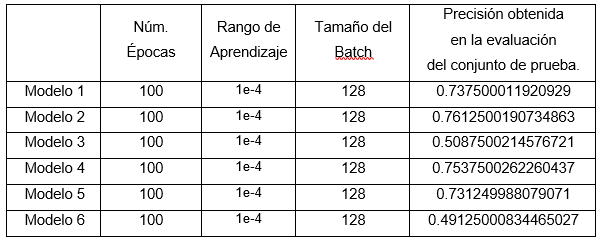

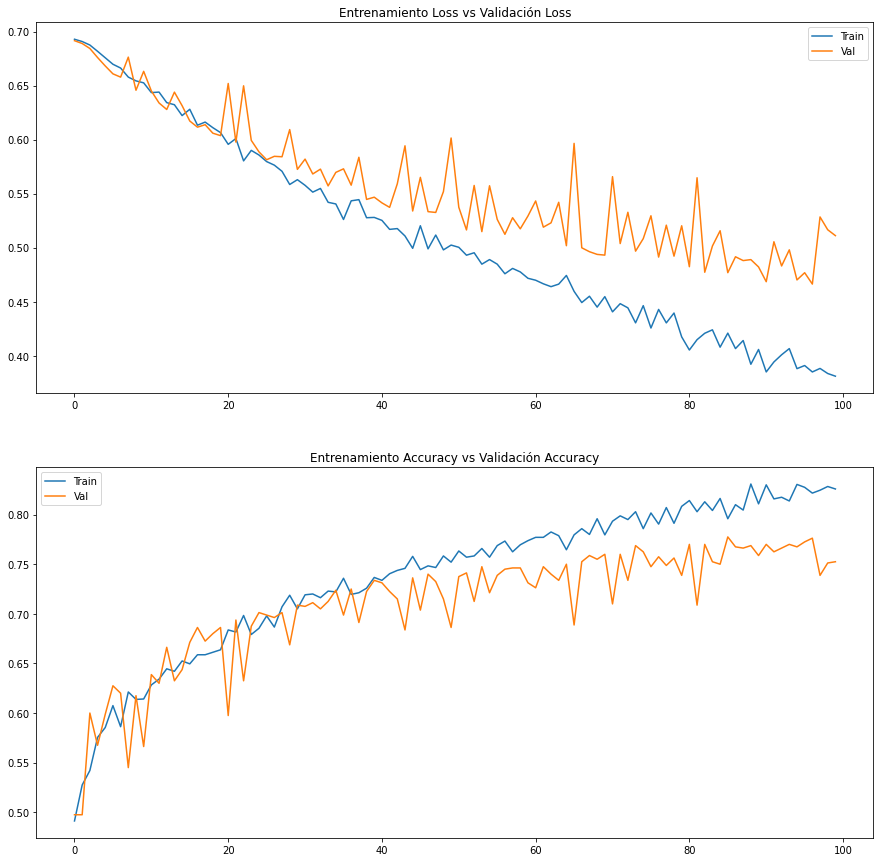

In [125]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))  
axs[0].plot(history1.history['loss']) 
axs[0].plot(history1.history['val_loss']) 
axs[0].title.set_text('Entrenamiento Loss vs Validación Loss') 
axs[0].legend(['Train', 'Val'])  
axs[1].plot(history1.history['accuracy']) 
axs[1].plot(history1.history['val_accuracy']) 
axs[1].title.set_text('Entrenamiento Accuracy vs Validación Accuracy') 
axs[1].legend(['Train', 'Val'])


### Guardar el modelo seleccionado en formato 

In [146]:
model1.save(path_h5 + 'model1.h5py')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab Notebooks/Deep Learning/model1.h5py/assets


In [147]:
del model1

In [22]:
nuevo_modelo = tf.keras.models.load_model(path_h5 + 'model1.h5py')

### Predicción del Modelo

In [23]:
y_pred = np.argmax(nuevo_modelo.predict(x_test), axis=1)

### Matriz de confusión

In [24]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)

[[368  19]
 [147 266]]


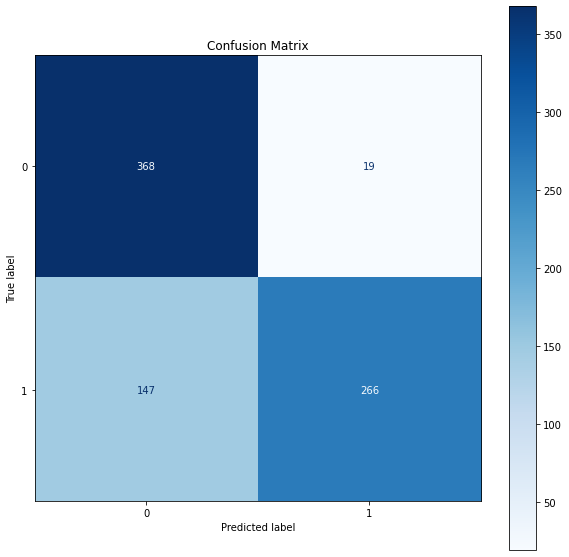

In [25]:
fig, ax = plt.subplots(figsize=(10, 10))
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = [0,1])
disp = disp.plot(ax=ax,cmap=plt.cm.Blues)
ax.set_title("Confusion Matrix")
plt.show()

### Reporte de la Clasificación

In [26]:
reporte = classification_report(np.argmax(y_test, axis=1), y_pred,target_names = categorias)
print(reporte)

              precision    recall  f1-score   support

        cats       0.71      0.95      0.82       387
        dogs       0.93      0.64      0.76       413

    accuracy                           0.79       800
   macro avg       0.82      0.80      0.79       800
weighted avg       0.83      0.79      0.79       800



### Función para clasificar el dataset de perros y gatos

Diseñar una función que tenga como parámetro de entrada  una imagen de perro y gato. Asi bien, diga que es. 

In [39]:
def model_clas(ruta):
  img = cv2.resize(cv2.cvtColor(cv2.imread(ruta), cv2.COLOR_BGR2RGB), (150, 150))
  img = np.asarray(img).astype('uint8')
  img = img.astype('float32')
  img /= 255.0
  plt.figure(figsize = (5, 5))
  plt.imshow(img)
  img_mod = img.reshape(1, 150, 150, 3)
  pred = np.argmax(nuevo_modelo.predict(img_mod), axis = 1)
 
  if pred == 0:
    Y_pred = 'gato'
  elif pred == 1:
    Y_pred = 'perro'
  return ('Es un', Y_pred, plt.show())

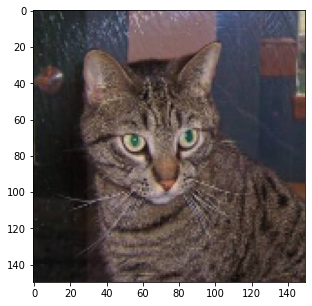

Es un perro


In [40]:
Prueba = model_clas('/content/cats_and_dogs_small/cats/cat.1.jpg')
print(Prueba[0], Prueba[1])

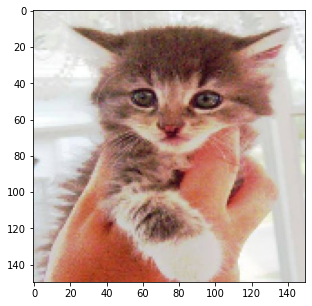

Es un perro


In [30]:
Prueba = model_clas('/content/cats_and_dogs_small/cats/cat.100.jpg')
print(Prueba[0], Prueba[1])

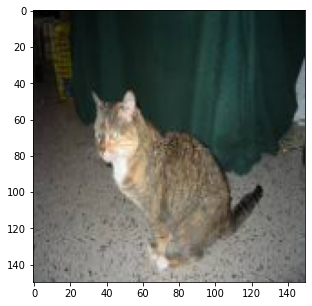

Es un gato


In [31]:
Prueba = model_clas('/content/cats_and_dogs_small/cats/cat.1555.jpg')
print(Prueba[0], Prueba[1])

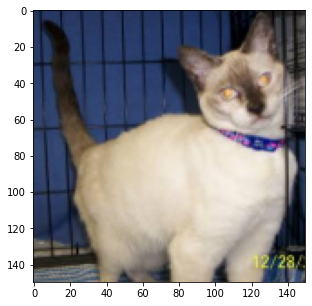

Es un gato


In [32]:
Prueba = model_clas('/content/cats_and_dogs_small/cats/cat.1079.jpg')
print(Prueba[0], Prueba[1])

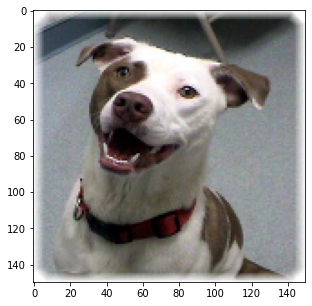

Es un perro


In [33]:
Prueba = model_clas('/content/cats_and_dogs_small/dogs/dog.101.jpg')
print(Prueba[0], Prueba[1])

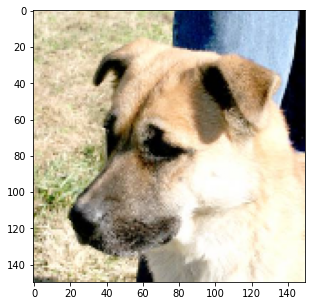

Es un perro


In [34]:
Prueba = model_clas('/content/cats_and_dogs_small/dogs/dog.1888.jpg')
print(Prueba[0], Prueba[1])

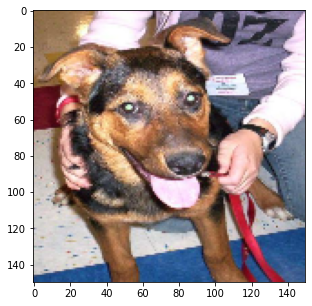

Es un perro


In [35]:
Prueba = model_clas('/content/cats_and_dogs_small/dogs/dog.1060.jpg')
print(Prueba[0], Prueba[1])

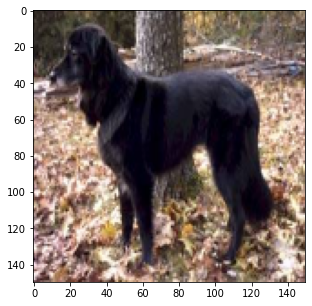

Es un gato


In [36]:
Prueba = model_clas('/content/cats_and_dogs_small/dogs/dog.1011.jpg')
print(Prueba[0], Prueba[1])

### Referencias

[1] H5PY. (2014) HDF5 para Python. Recuperado el día 11 de Marzo de 2022 de
https://docs.h5py.org/en/stable/

[2] H5PY. (2014) Guía de inicio rápido. Recuperado el día 11 de Marzo de 2022 de https://docs.h5py.org/en/stable/quick.html

[3] Puigalex. (2018) CNN desde cero. Recuperado el día 12 de Marzo de 2022 de
https://github.com/puigalex/AMP-Tech/blob/master/CNN%20desde%20cero/predict.py